In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
intervals = pd.DataFrame([[-259.1, -254.14], 
                          [-254.14, -251.902], 
                          [-251.902, -251], 
                          [-251, -250.4]], 
                         index=["Wuchiapingian",
                                "Changhsingian",
                                "Extinction",
                                "Griesbachian"], 
                         columns=["from", "to"])

In [3]:
intervals["mid"] = intervals.mean(axis=1)

In [4]:
intervals

,from,to,mid
Wuchiapingian,-259.100,-254.140,-256.620
Changhsingian,-254.140,-251.902,-253.021
Extinction,-251.902,-251.000,-251.451
Griesbachian,-251.000,-250.400,-250.700


In [5]:
auc_mean = [pd.read_csv(f"../results/TimeInterval{i}_AUC.csv", index_col=0).mean()[0] for i in range(1, 5)]
auc_min = [pd.read_csv(f"../results/TimeInterval{i}_AUC.csv", index_col=0).min()[0] for i in range(1, 5)]
auc_max = [pd.read_csv(f"../results/TimeInterval{i}_AUC.csv", index_col=0).max()[0] for i in range(1, 5)]

In [6]:
fi = pd.concat([pd.read_csv(f"../results/TimeInterval{i}_FI.csv", index_col=0).mean() for i in range(1, 5)], axis=1)

In [7]:
fi.columns = intervals.index

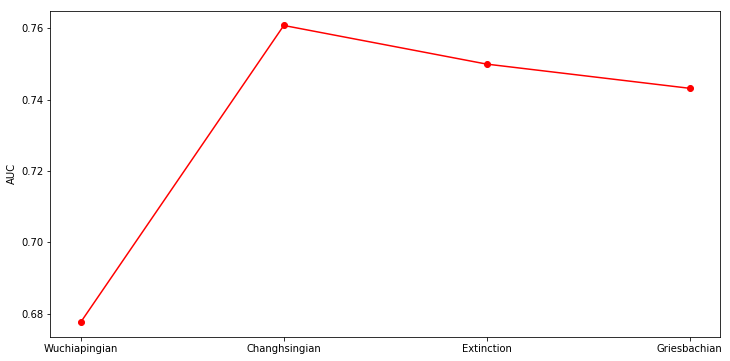

In [8]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(intervals.index, auc_mean, c="r", linestyle="-", marker="o")
ax.set_ylabel("AUC")
fig.savefig("../results/AUC.png", bbox_inches="tight")

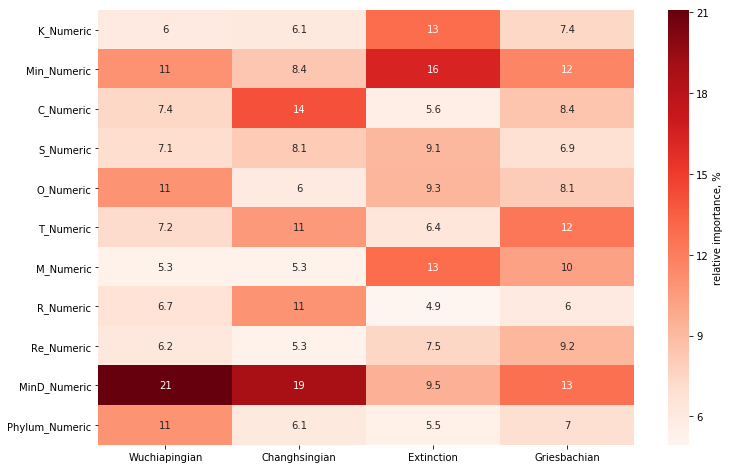

In [9]:
fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(fi, cmap="Reds", ax=ax, annot=True, cbar_kws={'label': 'relative importance, %'})
fig.savefig("../results/FI.png", bbox_inches="tight", dpi=300)